In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset

%load_ext autoreload
%autoreload 2

class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 3 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
size of X: (60000, 784)
size of Y: (60000, 10)


In [3]:
import math
from utils.functions import *

K = args.num_partition
N = args.num_users
T = 4

j_array = np.array(range(K+T))
print("j: ",(2*j_array+1)*math.pi/2/(K+T),'\n')

alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
print("alpha_array: ",alpha_array,'\n')

i_array = np.array(range(N))
z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
print("z_array: ",z_array,'\n')

j:  [0.15707963 0.4712389  0.78539816 1.09955743 1.41371669 1.72787596
 2.04203522 2.35619449 2.67035376 2.98451302] 

alpha_array:  [ 0.98768834  0.89100652  0.70710678  0.4539905   0.15643447 -0.15643447
 -0.4539905  -0.70710678 -0.89100652 -0.98768834] 

z_array:  [ 1.          0.9781476   0.91354546  0.80901699  0.66913061  0.5
  0.30901699  0.10452846 -0.10452846 -0.30901699 -0.5        -0.66913061
 -0.80901699 -0.91354546 -0.9781476 ] 



# 1. Original BACC allocation

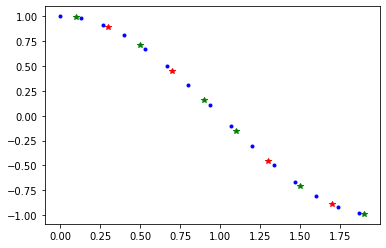

In [4]:
Noise_Alloc = [1,3,6,8]
Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

plt.plot(2*i_array/N,z_array,'b.')
plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='Noise')
plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='Signal')
plt.show()

<Figure size 432x288 with 0 Axes>

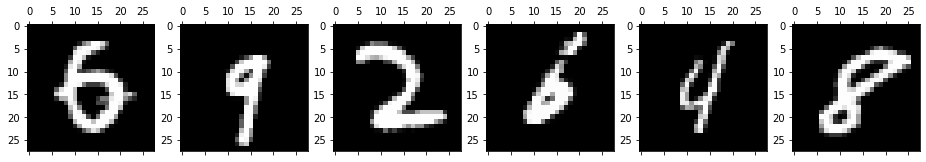

In [12]:


index_num = 3

index_sel = np.array(range(K))*Size_submatrices + index_num

input_images = encoding_input_array_np[index_sel,:]
input_labels = encoding_label_array_np[index_sel,:]

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,K):
    ax = fig.add_subplot(1,6,i+1)
    pixels = input_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

In [3]:
sigma = 10

X_tilde_case1,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = [1,3,6,8]) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
X_tilde_case2,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = [0,3,6,9])
X_tilde_case3,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, 1, _Noise_Alloc = [0,3,6,9])

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 

@BACC_Enc: N,K,T, m_i= 15 6 4 10000 



Encoded images & labels


<Figure size 432x288 with 0 Axes>

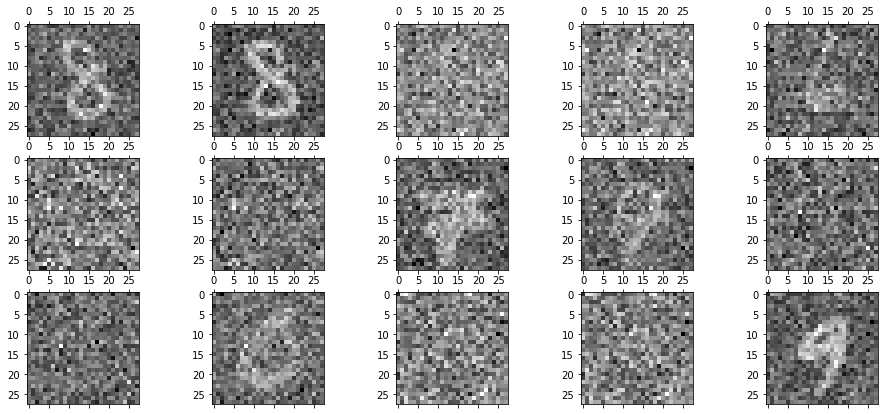

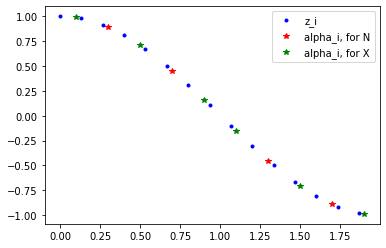

In [18]:
print("Encoded images & labels")
# print(X_tilde.shape)
# print(y_tilde.shape)
encoded_images = X_tilde_case1[:,index_num,:]
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

# for i in range(encoded_images.shape[0]):
#     print('label=', encoded_labels[i,:])
#     pixels = encoded_images[i,:].reshape((28, 28))
#     plt.imshow(pixels, cmap='gray')
#     plt.show()

Noise_Alloc = [1,3,6,8]
Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

plt.plot(2*i_array/N,z_array,'b.',label='z_i')
plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
plt.legend()
plt.show()


In [15]:
N = 15
K = 6
T = 7
sigma = 1
Noise_Alloc = [1,3,5,7,9,11,12]

X_tilde_case2,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc)



@BACC_Enc: N,K,T, m_i= 15 6 7 10000 



Encoded images & labels


<Figure size 432x288 with 0 Axes>

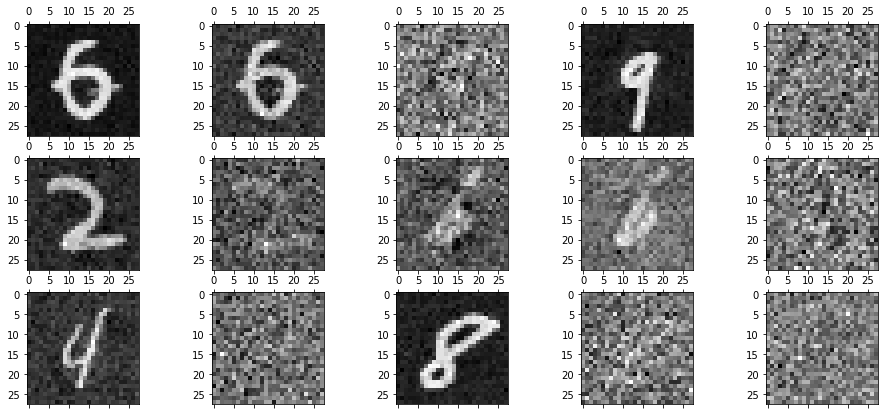

j:  [0.121 0.362 0.604 0.846 1.087 1.329 1.571 1.812 2.054 2.296 2.537 2.779
 3.021] 

alpha_array:  [ 9.927e-01  9.350e-01  8.230e-01  6.631e-01  4.647e-01  2.393e-01
 -1.608e-16 -2.393e-01 -4.647e-01 -6.631e-01 -8.230e-01 -9.350e-01
 -9.927e-01] 

z_array:  [ 1.     0.978  0.914  0.809  0.669  0.5    0.309  0.105 -0.105 -0.309
 -0.5   -0.669 -0.809 -0.914 -0.978] 



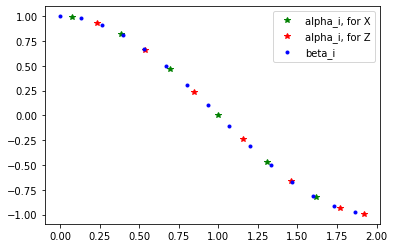

In [16]:
print("Encoded images & labels")
# print(X_tilde.shape)
# print(y_tilde.shape)
encoded_images = X_tilde_case2[:,index_num,:]
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

# for i in range(encoded_images.shape[0]):
#     print('label=', encoded_labels[i,:])
#     pixels = encoded_images[i,:].reshape((28, 28))
#     plt.imshow(pixels, cmap='gray')
#     plt.show()


Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

j_array = np.array(range(K+T))
print("j: ",(2*j_array+1)*math.pi/2/(K+T),'\n')

alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
print("alpha_array: ",alpha_array,'\n')

i_array = np.array(range(N))
z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
print("z_array: ",z_array,'\n')
# plt.plot(2*i_array/N,z_array,'b.')
# plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='Noise')
# plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='Signal')
# plt.show()

plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for Z')
plt.plot(2*i_array/N,z_array,'b.',label='beta_i')
plt.legend()
plt.show()

In [17]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

# training
loss_train_arr = []
loss_test_arr = []
acc_test_arr = []
net_best = None
best_loss = None

N_trials = 1
N_epochs = 30

# m_array = np.array(range(4,16)) # m is the number of received result @ master
T_array = np.array([7]) # m is the number of received result @ master

sigma_array = np.array([1, 5, 10])

loss_test_arr_v1 = np.empty((len(T_array),len(sigma_array),N_trials,N_epochs))
acc_test_arr_v1  = np.empty((len(T_array),len(sigma_array),N_trials,N_epochs))

for T_idx in range(len(T_array)):
    
    m = N # m is the number of received result @ master
    
    T = T_array[T_idx]
    
    if T == 0:
        Noise_Alloc = []
    elif T == 1:
        Noise_Alloc = [0]
    elif T == 2:
        Noise_Alloc = [0,2]
    elif T == 3:
        Noise_Alloc = [0,2,4]
    elif T == 4:
        Noise_Alloc = [1,3,5,7]
    elif T == 5:
        Noise_Alloc = [1,3,5,7,9]
    elif T == 6:
        Noise_Alloc = [1,3,5,7,9,11]
    elif T == 7:
        Noise_Alloc = [1,3,5,7,9,11,12] # np.random.choice(range(K+T), T, replace=False)
    elif T == 8:
        Noise_Alloc = [0,2,4,6,8,9,11,13] # np.random.choice(range(K+T), T, replace=False)
    elif T == 9:
        Noise_Alloc = [0,2,4,6,8,10,12,13,14] # np.random.choice(range(K+T), T, replace=False)
    elif T == 10:
        Noise_Alloc = [0,2,4,6,8,10,12,13,14,15] # np.random.choice(range(K+T), T, replace=False)
    elif T == 11:
        Noise_Alloc = [0,2,4,6,8,10,12,13,14,15,16] # np.random.choice(range(K+T), T, replace=False)
    else:
        Noise_Alloc = np.random.choice(range(K+T), T, replace=False)
        
    Signal_Alloc = []
    for i in range(K+T):
        if i not in Noise_Alloc:
            Signal_Alloc.append(i)
            
    j_array = np.array(range(K+T))
    # print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

    alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

    i_array = np.array(range(N))
    z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
    
    for sigma_idx in range(len(sigma_array)):
        
        sigma = sigma_array[sigma_idx]
    
        X_tilde,a,b = BACC_Enc_withNoise(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_withNoise(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        for trial_idx in range(N_trials):
            print('(T,sigma=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)

                coded_net = BACC_Enc_Model_withNoise(net_glob.cuda(), N, K, T, 0.01, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v1[T_idx][sigma_idx][trial_idx][iter] = acc_test
                loss_test_arr_v1[T_idx][sigma_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

@BACC_Enc: N,K,T, m_i= 15 6 7 10000 

@BACC_Enc: N,K,T, m_i= 15 6 7 10000 

(T,sigma= 7 1 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3025 
Accuracy: 1028/10000 (10.28%)

Round   0, Average loss 2.302 Test accuracy 10.280
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3000 
Accuracy: 2041/10000 (20.41%)

Round   1, Average loss 2.300 Test accuracy 20.410
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.5373 
Accuracy: 8780/10000 (87.80%)

Round   2, Average loss 1.537 Test accuracy 87.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.4189 
Accuracy: 9287/10000 (92.87%)

Round   3, Average loss 0.419 Test accuracy 92.870
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3289 
Accuracy: 9394/10000 (93.94%)

Round   4, Average loss 0.329 Test accuracy 93.940
sel


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  15, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  16, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 1009/10000 (10.09%)

Round  17, Average loss 2.303 Test accuracy 10.090
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3024 
Accuracy: 1135/10000 (11.35%)

Round  18, Average loss 2.302 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3023 
Accuracy: 1135/10000 (11.35%)

Round  19, Average loss 2.302 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 1135/10000 (11.35%)

Round  20, Average loss 2.303 Test accuracy 11.350
s

# 2. Proposed Allocation (Heuristic)

## 2.1. N=15, K=6, T=7

[ 1  2  3  4  5  6  7  8  9 10 11 12 13]


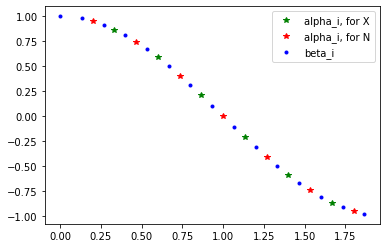

In [72]:
N = 15
K = 6
T = 7
Noise_Alloc = [0,2,4,6,8,10,12]

j_array_org = np.array(range(N))
stt_pos = int(np.floor((N-K-T)/2))

j_array = j_array_org[stt_pos:stt_pos+K+T]
print(j_array)
              
# j_array = j_array[]
# print("j: ",(2*j_array+1)*math.pi/2/(K+T),'\n')

alpha_array = np.cos((2*j_array+1)*math.pi/(2*N)) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

i_array = np.array(range(N))
z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


plt.plot((2*j_array[Signal_Alloc]+1)/(N),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
plt.plot((2*j_array[Noise_Alloc]+1)/(N),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
plt.plot(2*i_array/N,z_array,'b.',label='beta_i')
plt.legend()
plt.show()
          
          
# print("Encoded images & labels")
# # print(X_tilde.shape)
# # print(y_tilde.shape)
# encoded_images = X_tilde_case4[:,index_num,:]
# # print(encoded_images.shape)
# np.set_printoptions(precision=3)

# plt.gray()
# fig = plt.figure( figsize=(16,7) )
# for i in range(0,15):
#     ax = fig.add_subplot(3,5,i+1)
#     pixels = encoded_images[i,:].reshape((28, 28))
#     ax.matshow(pixels)
# plt.show()



@BACC_Enc: N,K,T, m_i= 15 6 7 10000 

Encoded images & labels


<Figure size 432x288 with 0 Axes>

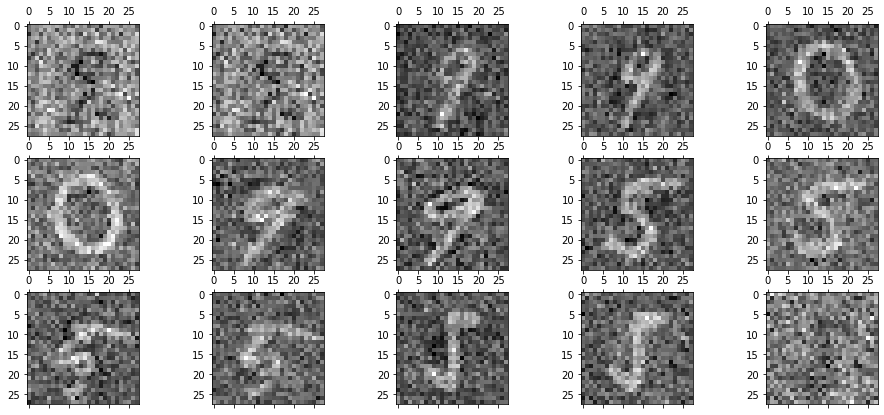

In [73]:
sigma = 1

X_tilde_case4,a,b = BACC_Enc_withNoise_v2(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)

index_num = 3

print("Encoded images & labels")
# print(X_tilde.shape)
# print(y_tilde.shape)
encoded_images = X_tilde_case4[:,index_num,:]
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

@BACC_Enc: N,K,T, m_i= 15 6 7 10000 

Encoded images & labels


<Figure size 432x288 with 0 Axes>

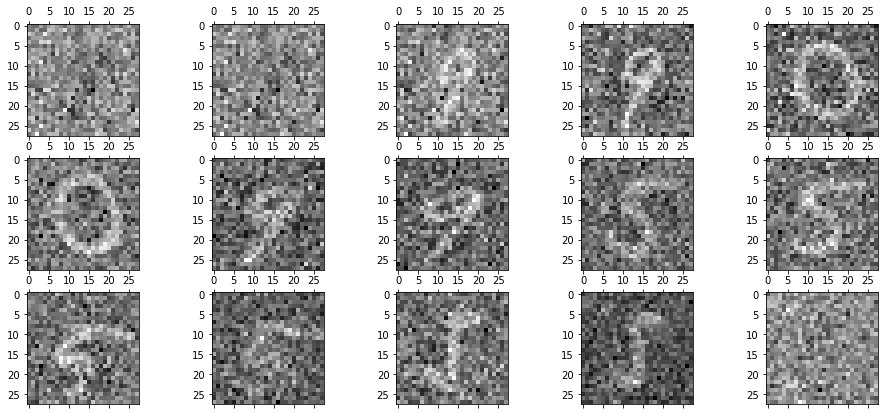

In [7]:
sigma = 1.5

X_tilde_case4,a,b = BACC_Enc_withNoise_v2(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)

index_num = 3

print("Encoded images & labels")
# print(X_tilde.shape)
# print(y_tilde.shape)
encoded_images = X_tilde_case4[:,index_num,:]
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

@BACC_Enc: N,K,T, m_i= 15 6 7 10000 

Encoded images & labels


<Figure size 432x288 with 0 Axes>

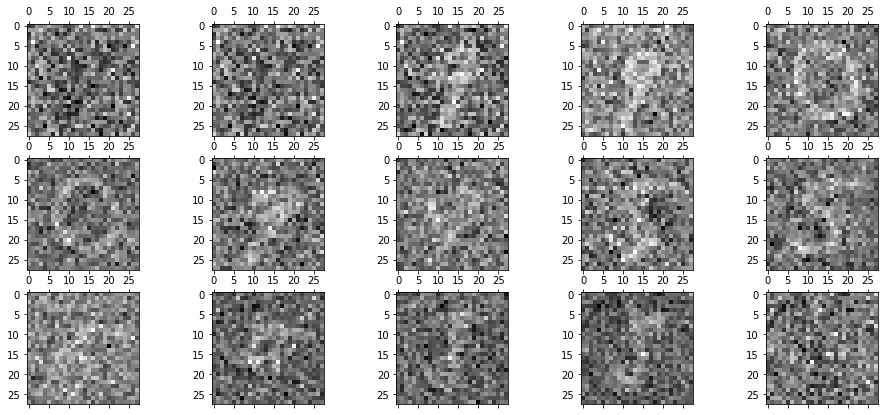

In [9]:
sigma = 2

X_tilde_case4,a,b = BACC_Enc_withNoise_v2(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)

index_num = 3

print("Encoded images & labels")
# print(X_tilde.shape)
# print(y_tilde.shape)
encoded_images = X_tilde_case4[:,index_num,:]
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

In [74]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 14
K = 6


# training



N_trials = 1
N_epochs = 30

# m_array = np.array(range(4,16)) # m is the number of received result @ master
alloc_Num = 1
sigma_array = np.array([1, 1.5, 2])


loss_test_arr_v5 = np.zeros((alloc_Num,len(sigma_array),N_trials,N_epochs))
acc_test_arr_v5  = np.zeros((alloc_Num,len(sigma_array),N_trials,N_epochs))

for alloc_idx in range(alloc_Num):
    


    
    T = 7
    
    if alloc_idx == 0:
        Noise_Alloc = [0,2,4,6,8,10,12]
#     elif alloc_idx == 1:
#         Noise_Alloc = [0,3,6,9]
#     elif alloc_idx == 2:
#         Noise_Alloc = [1,3,5,8]
#     elif alloc_idx == 3:
#         Noise_Alloc = [0,1,2,3]
#     elif alloc_idx == 4:
#         Noise_Alloc = [0,1,5,9]
#     elif alloc_idx == 5:
#         Noise_Alloc = [0,2,4,6]
    else:
        Noise_Alloc = [6,7,8,9]
    Signal_Alloc = []
    for i in range(K+T):
        if i not in Noise_Alloc:
            Signal_Alloc.append(i)
    
    j_array_org = np.array(range(N))
    stt_pos = int(np.floor((N-K-T)/2))

    j_array = j_array_org[stt_pos:stt_pos+K+T]

    # j_array = j_array[]
    # print("j: ",(2*j_array+1)*math.pi/2/(K+T),'\n')

    alpha_array = np.cos((2*j_array+1)*math.pi/(2*N)) #np.cos((2*j_array+1)*math.pi/(2*K))

    i_array = np.array(range(N))
    z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
    
    for sigma_idx in range(len(sigma_array)):
        
        sigma = sigma_array[sigma_idx]
        
        _Noise_label = np.ones((10000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_withNoise_v2(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_withNoise_v2(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v2(net_glob.cuda(), N, K, T, 0.01, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v5[alloc_idx][sigma_idx][trial_idx][iter] = acc_test
                loss_test_arr_v5[alloc_idx][sigma_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

@BACC_Enc: N,K,T, m_i= 14 6 7 10000 

@BACC_Enc: N,K,T, m_i= 14 6 7 10000 

(T, sigma)= 7 1.0 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]

Test set: Average loss: 2.3015 
Accuracy: 974/10000 (9.74%)

Round   1, Average loss 2.302 Test accuracy 9.740
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]

Test set: Average loss: 2.2859 
Accuracy: 2537/10000 (25.37%)

Round   2, Average loss 2.286 Test accuracy 25.370
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]

Test set: Average loss: 2.2178 
Accuracy: 7679/10000 (76.79%)

Round   3, Average loss 2.218 Test accuracy 76.790
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]

Test set: Average loss: 1.9933 
Accuracy: 9059/10000 (90.59%)

Round   4, Average loss 1.993 Test accuracy 90.590
selected users: [ 0 


Test set: Average loss: 1.8207 
Accuracy: 9024/10000 (90.24%)

Round  16, Average loss 1.821 Test accuracy 90.240
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]

Test set: Average loss: 1.8065 
Accuracy: 9199/10000 (91.99%)

Round  17, Average loss 1.807 Test accuracy 91.990
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]

Test set: Average loss: 1.8200 
Accuracy: 9143/10000 (91.43%)

Round  18, Average loss 1.820 Test accuracy 91.430
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]

Test set: Average loss: 1.8270 
Accuracy: 9054/10000 (90.54%)

Round  19, Average loss 1.827 Test accuracy 90.540
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]

Test set: Average loss: 1.8057 
Accuracy: 9079/10000 (90.79%)

Round  20, Average loss 1.806 Test accuracy 90.790
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]

Test set: Average loss: 1.8049 
Accuracy: 9124/10000 (91.24%)

Round  21, Average loss 1.805 Test accuracy 91.240
selected u

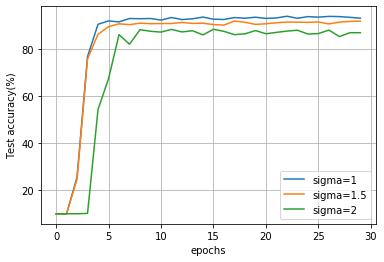

In [75]:
plt.plot(acc_test_arr_v5[0,0,0,0:30],label='sigma=1')
plt.plot(acc_test_arr_v5[0,1,0,0:30],label='sigma=1.5')
plt.plot(acc_test_arr_v5[0,2,0,0:30],label='sigma=2')
# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

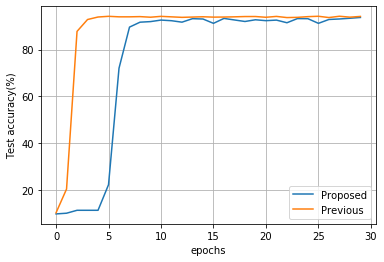

In [20]:
plt.plot(acc_test_arr_v5[0,0,0,0:30],label='Proposed')
plt.plot(acc_test_arr_v1[0,0,0,:],label='Previous')
# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

In [47]:
def MIS_BACC(_alpha_array_Signal, _alpha_array_Noise, _beta_array, _P, _sigma):
    '''
    alpha_array_Signal : size = K
    alpha_array_Noise  : size = T
    beta_array         : size = t // set of beta's assigned for colluding users    
    '''
    
    _t = len(_beta_array)
    _K = len(_alpha_array_Signal)
    _T = len(_alpha_array_Noise)
    
    _W = np.ones((_t,_K + _T))
    _W[:,1::2] = -1
    
    _alpha_array = np.concatenate((_alpha_array_Signal,_alpha_array_Noise))
#     print(_alpha_array)
    
    _U = np.reshape(_beta_array,(_t,1)) - np.reshape(_alpha_array,(1,_K+_T))
    _U = 1/_U
    _U = _U * _W
    
    for i in range(_t):
        denom = np.sum(_U[i,:])
        _U[i,:] = _U[i,:] / denom
    
    _L       = _U[:,0:_K]
    _L_tilde = _U[:,_K:_K+_T]

    
    _SIG = np.matmul(_L,np.transpose(_L))
    _SIG_tilde = np.matmul(_L_tilde, np.transpose(_L_tilde))
    _SIG_tilde_Inv = np.linalg.inv(_SIG_tilde)
    
    _D = _P/_sigma * np.matmul(_SIG_tilde_Inv, _SIG)
        
    return np.log2(np.linalg.det(np.identity(_t) + _D))


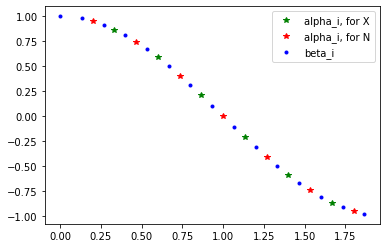

0
0.19855788932934793

1
0.08999737929388836

2
0.6840069830124624

3
1.104827716833878

4
0.8962296689608829

5
1.0455854014509995

6
0.9607587709727529

7
1.0033688954768598

8
1.0033688954768616

9
0.9607587709727535

10
1.0455854014509962

11
0.8962296689608886

12
1.1048277168338752

13
0.6840069830124569

14
0.08999737929388836



In [49]:
N = 15
K = 6
T = 7
Noise_Alloc = [0,2,4,6,8,10,12]

j_array_org = np.array(range(N))
stt_pos = int(np.floor((N-K-T)/2))

j_array = j_array_org[stt_pos:stt_pos+K+T]
# print(j_array)
              
# j_array = j_array[]
# print("j: ",(2*j_array+1)*math.pi/2/(K+T),'\n')

alpha_array = np.cos((2*j_array+1)*math.pi/(2*N)) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

i_array = np.array(range(N))
z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

plt.plot((2*j_array[Signal_Alloc]+1)/(N),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
plt.plot((2*j_array[Noise_Alloc]+1)/(N),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
plt.plot(2*i_array/N,z_array,'b.',label='beta_i')
plt.legend()
plt.show()

for j in range(len(z_array)):
    print(j)
    print(MIS_BACC(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,1))
    print()
    
# print(MIS_BACC(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],z_array[2:8], 1,1))

In [57]:
print(MIS_BACC(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],z_array[[2,3,4]], 1,1))

5.75496195538358


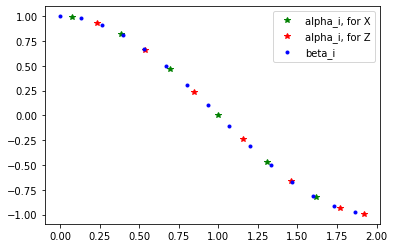

0
6.261774685426437

1
3.2697320585750673

2
0.178618195117625

3
5.520614470832256

4
0.004114685533101816

5
3.855179058997197

6
0.34564371633696517

7
1.3160396156092995

8
1.3072615583421199

9
0.3356102543277382

10
3.7709940071128982

11
0.003636644877110382

12
5.193048300244356

13
0.0772807530719738

14
0.012930697413391137



In [46]:
N = 15
K = 6
T = 7
sigma = 1
Noise_Alloc = [1,3,5,7,9,11,12]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

j_array = np.array(range(K+T))
# print("j: ",(2*j_array+1)*math.pi/2/(K+T),'\n')

alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

i_array = np.array(range(N))
z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for Z')
plt.plot(2*i_array/N,z_array,'b.',label='beta_i')
plt.legend()
plt.show()

for j in range(len(z_array)):
    print(j)
    print(MIS_BACC(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,1))
    print()

# K=3, Proposed Method

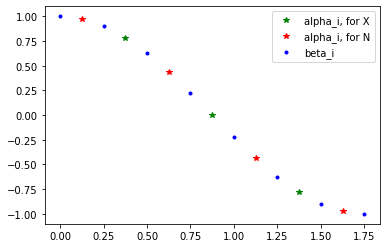

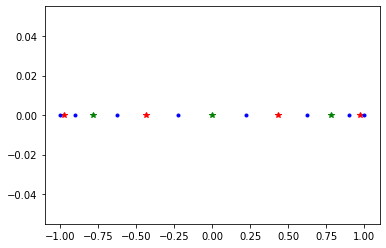

0
0.020056775093613748

1
0.46747084066592853

2
1.1076792478379605

3
0.924085578595572

4
0.924085578595572

5
1.107679247837963

6
0.4674708406659294

7
0.020056775093613432



In [101]:
N = 8
K = 3
T = 4
Noise_Alloc = [0,2,4,6]

j_array_org = np.array(range(N))
stt_pos = int(np.floor((N-K-T)/2))

j_array = j_array_org[stt_pos:stt_pos+K+T]
# print(j_array)
              
# j_array = j_array[]
# print("j: ",(2*j_array+1)*math.pi/2/(K+T),'\n')

alpha_array = np.cos((2*j_array+1)*math.pi/(2*(N-1))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

i_array = np.array(range(N))
z_array = np.cos(i_array*2*math.pi/(N-1)/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

plt.plot((2*j_array[Signal_Alloc]+1)/(N),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
plt.plot((2*j_array[Noise_Alloc]+1)/(N),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
plt.plot(2*i_array/N,z_array,'b.',label='beta_i')
plt.legend()
plt.show()

plt.plot(alpha_array[Signal_Alloc],0*np.ones(len(Signal_Alloc)),'g*')
plt.plot(alpha_array[Noise_Alloc],0*np.ones(len(Noise_Alloc)),'r*')
plt.plot(z_array,0*np.ones(len(z_array)),'b.')
# plt.legend()
plt.show()

for j in range(len(z_array)):
    print(j)
    print(MIS_BACC(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,1))
    print()
    
# print(MIS_BACC(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],z_array[2:8], 1,1))

In [94]:
N = 8
K = 3
T = 4
Noise_Alloc = [0,2,4,6]

sigma = 1
X_tilde_s1,a,b = BACC_Enc_withNoise_v2(encoding_input_array_np, N, K, T, 1, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
X_tilde_s15,a,b = BACC_Enc_withNoise_v2(encoding_input_array_np, N, K, T, 1.5, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
X_tilde_s2,a,b = BACC_Enc_withNoise_v2(encoding_input_array_np, N, K, T, 2, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)

@BACC_Enc: N,K,T, m_i= 8 3 4 20000 

@BACC_Enc: N,K,T, m_i= 8 3 4 20000 

@BACC_Enc: N,K,T, m_i= 8 3 4 20000 



Encoded images & labels


<Figure size 432x288 with 0 Axes>

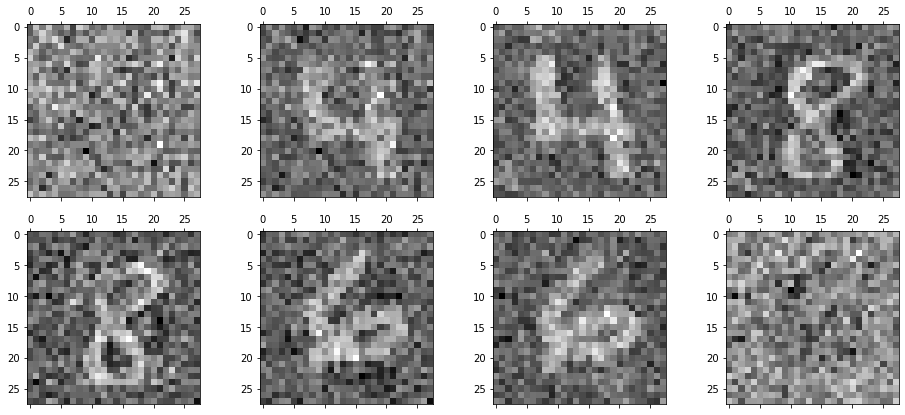

<Figure size 432x288 with 0 Axes>

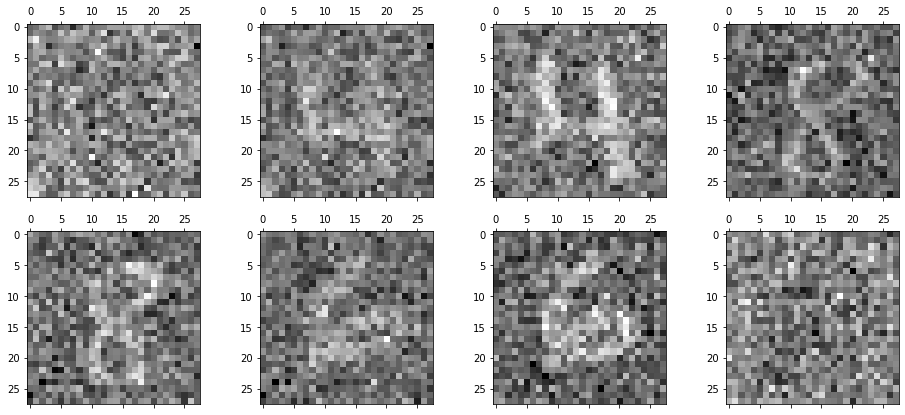

<Figure size 432x288 with 0 Axes>

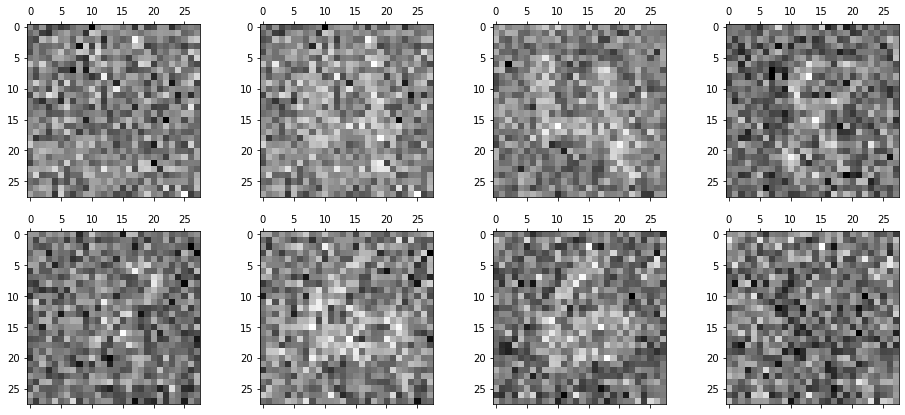

In [96]:

index_num = 0

print("Encoded images & labels")
# print(X_tilde.shape)
# print(y_tilde.shape)
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(16,7) )

encoded_images = X_tilde_s1[:,index_num,:]
for i in range(0,N):
    ax = fig.add_subplot(2,4,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

plt.gray()
fig = plt.figure( figsize=(16,7) )
encoded_images = X_tilde_s15[:,index_num,:]
for i in range(0,N):
    ax = fig.add_subplot(2,4,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

plt.gray()
fig = plt.figure( figsize=(16,7) )
encoded_images = X_tilde_s2[:,index_num,:]
for i in range(0,N):
    ax = fig.add_subplot(2,4,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

In [2]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 8
K = 3
T = 4

# training



N_trials = 1
N_epochs = 30

# m_array = np.array(range(4,16)) # m is the number of received result @ master
alloc_Num = 1
sigma_array = np.array([1, 1.5, 2,3,4])


loss_test_arr_v5 = np.zeros((alloc_Num,len(sigma_array),N_trials,N_epochs))
acc_test_arr_v5  = np.zeros((alloc_Num,len(sigma_array),N_trials,N_epochs))

for alloc_idx in range(alloc_Num):
    


    
    
    
    if alloc_idx == 0:
        Noise_Alloc = [0,2,4,6]
#     elif alloc_idx == 1:
#         Noise_Alloc = [0,3,6,9]
#     elif alloc_idx == 2:
#         Noise_Alloc = [1,3,5,8]
#     elif alloc_idx == 3:
#         Noise_Alloc = [0,1,2,3]
#     elif alloc_idx == 4:
#         Noise_Alloc = [0,1,5,9]
#     elif alloc_idx == 5:
#         Noise_Alloc = [0,2,4,6]
    else:
        Noise_Alloc = [6,7,8,9]
    Signal_Alloc = []
    for i in range(K+T):
        if i not in Noise_Alloc:
            Signal_Alloc.append(i)
    
    j_array_org = np.array(range(N))
    stt_pos = int(np.floor((N-K-T)/2))

    j_array = j_array_org[stt_pos:stt_pos+K+T]

    # j_array = j_array[]
    # print("j: ",(2*j_array+1)*math.pi/2/(K+T),'\n')

    alpha_array = np.cos((2*j_array+1)*math.pi/(2*(N-1))) #np.cos((2*j_array+1)*math.pi/(2*K))

    i_array = np.array(range(N))
    z_array = np.cos(i_array*2*math.pi/(N-1)/2) # np.cos(i_array*2*math.pi/N/2)
    
    for sigma_idx in range(len(sigma_array)):
        
        sigma = sigma_array[sigma_idx]
        
        _Noise_label = np.ones((20000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_withNoise_v2(encoding_input_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_withNoise_v2(encoding_label_array_np, N, K, T, sigma, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v2(net_glob.cuda(), N, K, T, 0.01, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v5[alloc_idx][sigma_idx][trial_idx][iter] = acc_test
                loss_test_arr_v5[alloc_idx][sigma_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

@BACC_Enc: N,K,T, m_i= 8 3 4 20000 

@BACC_Enc: N,K,T, m_i= 8 3 4 20000 

(T, sigma)= 4 1.0 )  0 -th Trial!!
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.3017 
Accuracy: 1760/10000 (17.60%)

Round   0, Average loss 2.302 Test accuracy 17.600
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.2835 
Accuracy: 1135/10000 (11.35%)

Round   1, Average loss 2.284 Test accuracy 11.350
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.0413 
Accuracy: 9321/10000 (93.21%)

Round   2, Average loss 2.041 Test accuracy 93.210
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.8092 
Accuracy: 9374/10000 (93.74%)

Round   3, Average loss 1.809 Test accuracy 93.740
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.6223 
Accuracy: 9518/10000 (95.18%)

Round   4, Average loss 1.622 Test accuracy 95.180
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.6462 
Accuracy: 9588/10000 (95.88%)

Round   5, Average loss 1.646 Test accuracy 95.8


Test set: Average loss: 1.5407 
Accuracy: 9460/10000 (94.60%)

Round  24, Average loss 1.541 Test accuracy 94.600
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.5826 
Accuracy: 9446/10000 (94.46%)

Round  25, Average loss 1.583 Test accuracy 94.460
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.5636 
Accuracy: 9501/10000 (95.01%)

Round  26, Average loss 1.564 Test accuracy 95.010
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.4926 
Accuracy: 9384/10000 (93.84%)

Round  27, Average loss 1.493 Test accuracy 93.840
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.5021 
Accuracy: 9436/10000 (94.36%)

Round  28, Average loss 1.502 Test accuracy 94.360
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.5831 
Accuracy: 9242/10000 (92.42%)

Round  29, Average loss 1.583 Test accuracy 92.420
@BACC_Enc: N,K,T, m_i= 8 3 4 20000 

@BACC_Enc: N,K,T, m_i= 8 3 4 20000 

(T, sigma)= 4 2.0 )  0 -th Trial!!
selected users: [0 1 2 3 4 5 6 


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  18, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  19, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  20, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  21, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  22, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  23, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  24, Average loss 2.303 Test accuracy 9.800
selected use

(1, 5, 1, 30)


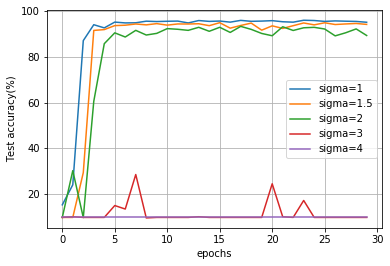

In [102]:
# sigma_array = np.array([1, 1.5, 2,3,4,5])
print(np.shape(acc_test_arr_v5))

plt.plot(acc_test_arr_v5[0,0,0,0:30],label='sigma=1')
plt.plot(acc_test_arr_v5[0,1,0,0:30],label='sigma=1.5')
plt.plot(acc_test_arr_v5[0,2,0,0:30],label='sigma=2')
plt.plot(acc_test_arr_v5[0,3,0,0:30],label='sigma=3')
plt.plot(acc_test_arr_v5[0,4,0,0:30],label='sigma=4')
# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

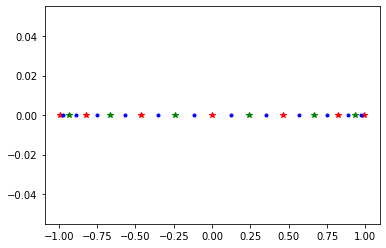

In [97]:
N = 12
K = 6
T = 7
Noise_Alloc = [0,2,4,6,8,10,12]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

alloc_Num = 0

j_array = np.array(range(K+T))
i_array = np.array(range(K+T))
    
if alloc_Num == 0:
    alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
    z_array = np.cos(i_array[1:]*2*math.pi/(K+T)/2) 
else:    
    alpha_array = (2*j_array+1)/(K+T)-1
    z_array = 2*i_array[1:]/(K+T)-1
    
plt.plot(alpha_array[Signal_Alloc],0*np.ones(len(Signal_Alloc)),'g*')
plt.plot(alpha_array[Noise_Alloc],0*np.ones(len(Noise_Alloc)),'r*')
plt.plot(z_array,0*np.ones(len(z_array)),'b.')
# plt.legend()
plt.show()

19
[-0.902423505384313, -0.9017647076171516, -0.5685688789440522, -0.5649531702968691, -0.28704085704720894, -0.2843807631712876, -0.2821348934859449, -0.2810511435468208, -0.2741032896954829, 0.27730610118332844, 0.27959356225327303, 0.2803987633100744, 0.2820504036960154, 0.28454464172806393, 0.56063417262631, 0.5636202323360218, 0.5652963539242486, 0.5660319578511004, 0.5670703399114756]


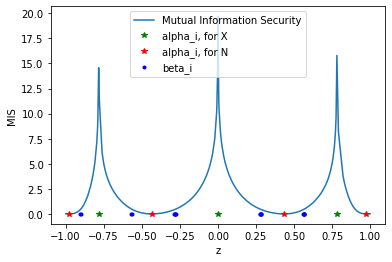

In [7]:
K = 3
T = 4
Noise_Alloc = [0,2,4,6]
sigma = 1

N = 8

j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T)))

i_array = np.array(range(N))
beta_array = np.cos(i_array*2*math.pi/(N-1)/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

N = 500
z_array = np.random.uniform(-1,1,N) #np.cos(i_array[1:]*2*math.pi/(K+T)/2) # np.cos(i_array*2*math.pi/N/2)
z_array = np.sort(z_array)
MIS_array = np.zeros((N))
# print(z_array)

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

B = [0.5]

z_array_0 = []

for j in range(len(z_array)):
    MIS_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma)
    
    if MIS_array[j] < 0.5 and MIS_array[j]>0.4:
        z_array_0.append(z_array[j])

#     print('(beta index, MIS) = ',j,',',MIS_array[j])
#     print()



print(len(z_array_0))
print(z_array_0)


plt.plot(z_array, MIS_array, label='Mutual Information Security')
plt.plot(alpha_array[Signal_Alloc],0*np.ones(len(Signal_Alloc)),'g*',label='alpha_i, for X')
plt.plot(alpha_array[Noise_Alloc],0*np.ones(len(Noise_Alloc)),'r*',label='alpha_i, for N')
plt.plot(z_array_0,0*np.ones(len(z_array_0)),'b.',label='beta_i')
plt.xlabel('z')
plt.ylabel('MIS')
plt.legend()
plt.show()
    

# print(alpha_array[Signal_Alloc])
# print(alpha_array[Noise_Alloc])
# print(alpha_array)

# plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
# plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
# plt.plot(2*i_array[1:]/(K+T), z_array,'b.',label='beta_i')
# plt.legend()
# plt.show()

In [8]:
sigma = 1

z_array_sel = z_array_0
X_tilde_s0,a,b = BACC_Enc_Data_v3(encoding_input_array_np, len(z_array_sel), K, T, sigma, alpha_array, z_array_sel, _Noise_Alloc = Noise_Alloc)


@BACC_Enc: N,K,T, m_i= 19 3 4 20000 



Encoded images B<0.5


<Figure size 432x288 with 0 Axes>

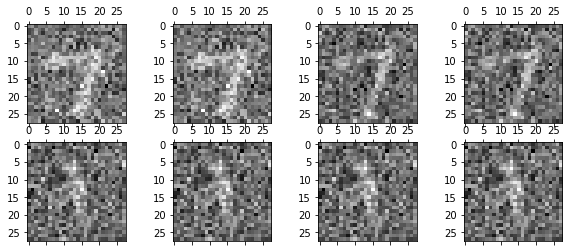

In [10]:
index_num = 0

print("Encoded images B<0.5")
# print(X_tilde.shape)
# print(y_tilde.shape)
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(10,4) )

encoded_images = X_tilde_s0[:,index_num,:]
for i in range(0,8):
    ax = fig.add_subplot(2,4,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()